In [1]:
#IMPORTS
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

GRAPHIC 1 - ECONOMIC PERFORMANCE SUMMARY

<ipython-input-3-f19df61473c0>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ipc_ng_nacional_tasa_variacion_mensual"].iloc[0]=100


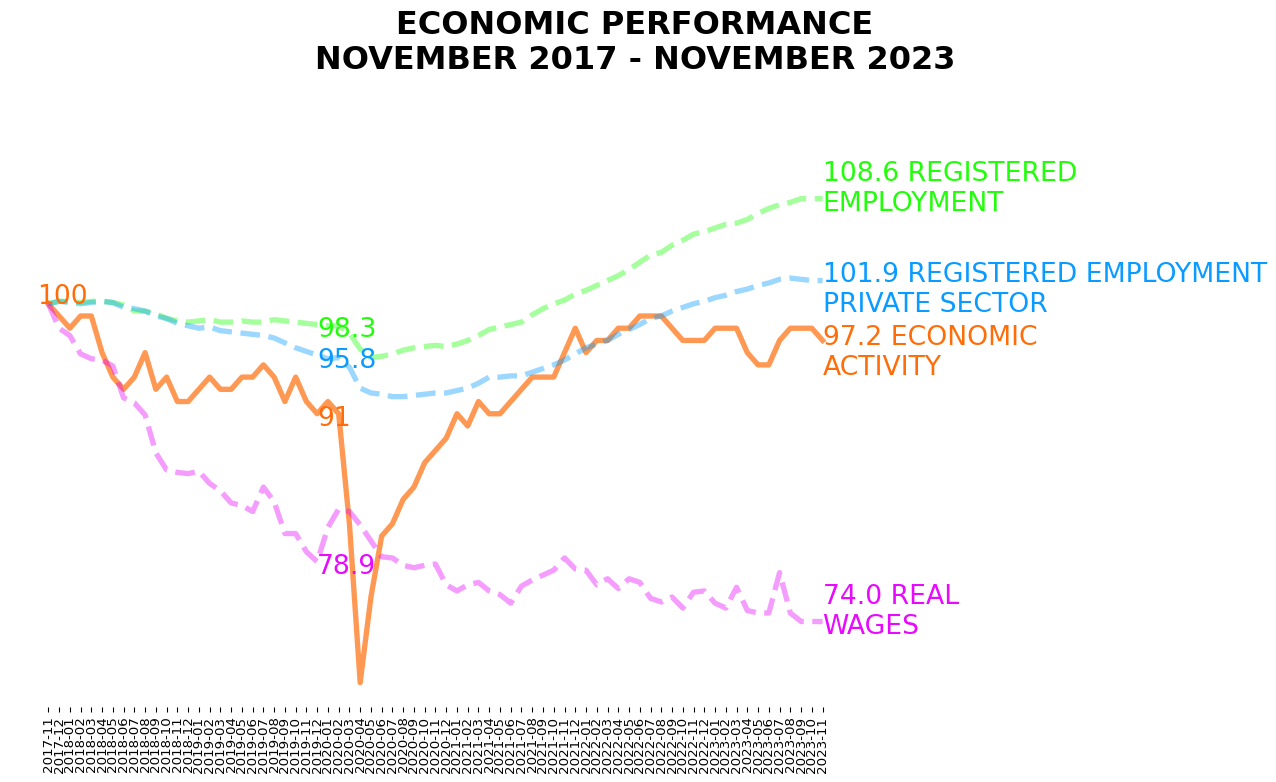

In [3]:
"""
This graph seeks to show the evolution of certain economic indicators in the period starting from the month with the highest level of economic activity (EMAE)
of the previous government (MACRI), until the last month with available information.

The indicators are: Level of registered employment, Level of registered employment in the private sector, Level of economic activity, and Level of real salary
The first three indicators are obtained directly from the dataset, but the real salary is obtained by deflating the values ​​of the dataset due to inflation.
"""

#DATASETS
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")
TRA = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/151/distribution/151.1/download/trabajadores-registrados-modalidad-ocupacional-principal-mensual-total-pais-miles-base-2012.csv")
ISAL = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/149/distribution/149.1/download/indice-salarios-periodicidad-mensual-base-octubre-2016.csv")
IPC = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv")

#DEFINITION OF THE PERIOD TO BE ANALYZED (initial date and end date)
#The final date is the last month with available information on the level of economic activity.
#iloc allows accessing the value using the position number
fecha_final=EMAE['indice_tiempo'].iloc[-1]
#The initial date is the month in which the EMAE shows a higher level during the previous government
#We filter so that only the data from that government period remains (2015/12 to 2020/01) and we order from lowest to highest using the relevant column
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#CALCULATION OF REAL SALARY
#I put together a new dataframe where the dataframe that contains the salary information and the one that contains inflation data are ordered by time period.
dfs=[ISAL, IPC]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
#I trim the df so that it only includes the period between start_date and end_date. I also use reset_index because later it will help me use loc,
#that allows access to the values ​​using the index
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()
#To calculate the real salary series I need:
#1-build accumulated inflation series
#To construct base 100 inflation index I put 100 in the initial value of the series
df["ipc_ng_nacional_tasa_variacion_mensual"].iloc[0]=100
#Using the following for loop I replace the monthly inflation values ​​of the dataset (starting from the second position) with the accumulated inflation values
for i in range(1, len(df)):
  df.loc[i,'ipc_ng_nacional_tasa_variacion_mensual'] = df.loc[i-1,'ipc_ng_nacional_tasa_variacion_mensual'] * (df.loc[i,'ipc_ng_nacional_tasa_variacion_mensual'] + 1)
#2-divide the nominal value of the salary index by the value of the corresponding accumulated inflation, divided by the initial value of the inflation series (100)
#This is "Salario_real_mes_x"="Salario_nominal_mes_x"/("Accumulated_inflation_month_x"/"Accumulated_inflation_month_0")
#I created a new column "calculo" where I copied each accumulated inflation value, divided by the initial value of the inflation series.
df["calculo"]=df.loc[:,'ipc_ng_nacional_tasa_variacion_mensual'].div(df.iloc[0]['ipc_ng_nacional_tasa_variacion_mensual'])
#Next, I define a formula that will also allow me to perform the missing operation for the calculation of the real salary for each month,
#calculate the percentage variation of the real salary month by month, which is necessary to construct the real salary variation index
def prueba (number):
    return number.div(df["calculo"].values).pct_change()
columnas_corrientes=['indice_salarios']
df[columnas_corrientes] = df[columnas_corrientes].apply(prueba)
#Now I build the real salary index
df.loc[0, columnas_corrientes]=100
for i in range(1, len(df)):
  df.loc[i, columnas_corrientes] = df.loc[i-1, columnas_corrientes] * (df.loc[i, columnas_corrientes]+1)

#CALCULATION OF THE SERIES FOR THE FOUR INDICATORS
#Once the calculation of the real salary has been completed, we construct the series of all the indicators
#I select the relevant columns and create a new dataframe where they are ordered by time period
indicadores=["emae_desestacionalizada", "total_sin_estac", "asalariados_priv_sin_estac", "indice_salarios"]
dfs=[EMAE,TRA, df]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()
#I calculate the monthly percentage variations for each indicator
def prueba (number):
    return number.pct_change()
df[indicadores] = df[indicadores].apply(prueba)
df.loc[0, indicadores]=100
for i in range(1, len(df)):
  df.loc[i, indicadores] = df.loc[i-1, indicadores] * (df.loc[i, indicadores]+1)

#GRAPHIC
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#I define the variables to graph
x=df["indice_tiempo"].str[:7]
y1=df["emae_desestacionalizada"].astype(int)
y2=df["total_sin_estac"].round(1)
y3=df["asalariados_priv_sin_estac"].round(1)
y4=df["indice_salarios"].round(1)

#I define the lines and their characteristics
plt.plot(x, y1, color="#ff6d09", linewidth=4, alpha=0.7)
plt.plot(x, y2, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y3, color='#099BFF', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y4, color='#E809FF', linewidth=4, alpha=0.4, linestyle='dashed')

#rotated x axis labels
plt.tick_params(axis='x', rotation=90)
#I take out the x and y axes
plt.box(False)
#I take off the y axis labels
plt.yticks([])

#annotations on the graph
valor_indice=x[x == "2019-12"].index[0]
plt.text(x.tail(1), y2.tail(1)-1, df["total_sin_estac"].iloc[-1].round(1).astype(str)+" REGISTERED \nEMPLOYMENT", horizontalalignment='left', color='#20FF09', fontsize=20)
plt.text(x.tail(1), y3.tail(1)-2.5, df["asalariados_priv_sin_estac"].iloc[-1].round(1).astype(str)+" REGISTERED EMPLOYMENT\nPRIVATE SECTOR", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(x.tail(1), y4.tail(1)-1, df["indice_salarios"].iloc[-1].round(1).astype(str)+" REAL\nWAGES", horizontalalignment='left', color='#E809FF', fontsize=20)
plt.text(x.tail(1), y1.tail(1)-2.8, df["emae_desestacionalizada"].iloc[-1].round(1).astype(str)+" ECONOMIC\nACTIVITY", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text(-1, y1.head(1), "100", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text("2019-12", y1[valor_indice]-1, y1[valor_indice].astype(str), horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text("2019-12", y2[valor_indice]-1, y2[valor_indice].astype(str), horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text("2019-12", y3[valor_indice]-1, y3[valor_indice].astype(str), horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text("2019-12", y4[valor_indice]-1, y4[valor_indice].astype(str), horizontalalignment='left',  color='#E809FF', fontsize=20)

#function that generates the name of a month in the chart
EMAE["nombre_mes"]=EMAE["indice_tiempo"].str[5:7]
meses = {"01":"JANUARY","02":"FEBRUARY","03":"MARCH","04":"APRIL","05":"MAY","06":"JUNE","07":"JULY","08":"AUGUST","09":"SEPTEMBER","10":"OCTOBER","11":"NOVEMBER","12": "DECEMBER"}
EMAE['nombre_mes'].replace(meses, inplace=True)

my_suptitle = fig.suptitle("ECONOMIC PERFORMANCE\n"+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+EMAE["nombre_mes"].iloc[-1]+" "+
                           EMAE["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.08, color="black")
plt.tight_layout()

plt.show()

GRAPH 2 - EVOLUTION OF INCOME (INDEC WAGES INDEX)

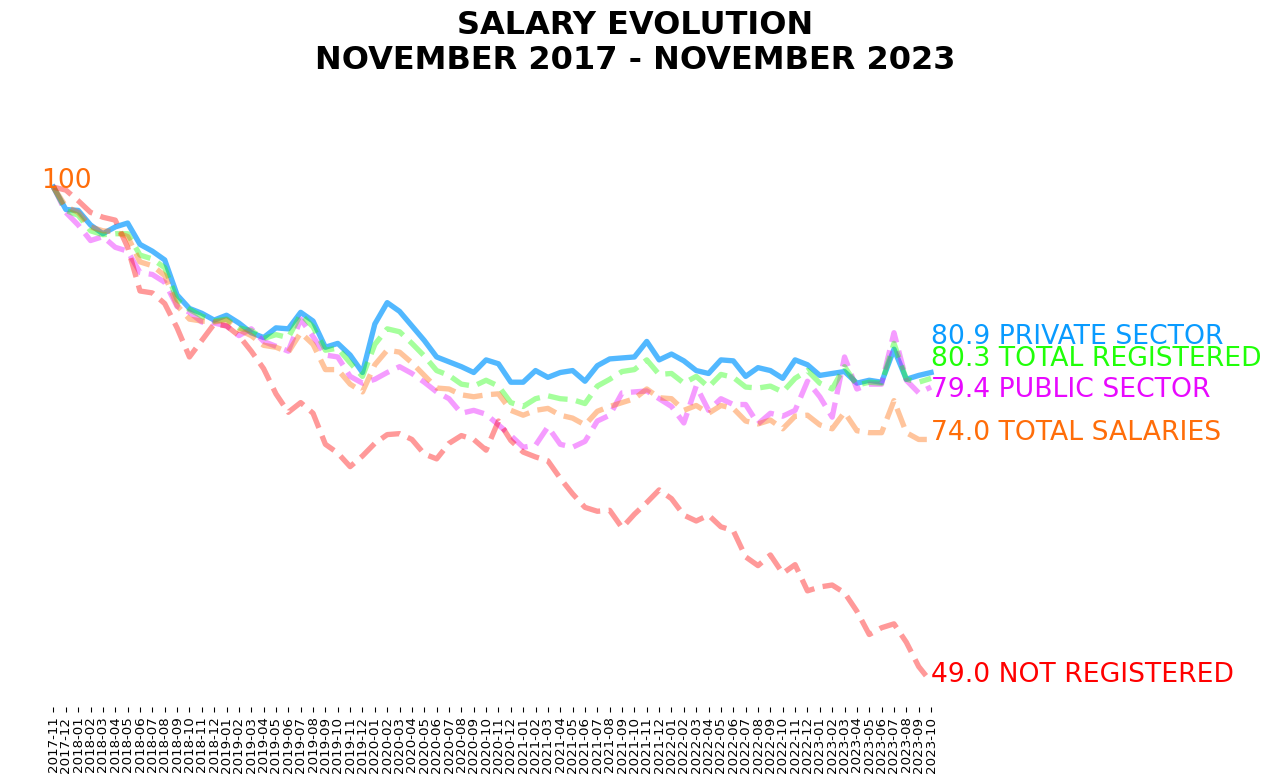

In [4]:
"""
This graph seeks to show the evolution of the salary indicators published by the INDEC in the period starting from the month with the highest level of economic activity (EMAE)
of the previous government (MACRI), until the last month with available information.
The real salary level is obtained by deflating the dataset values ​​for inflation.
"""
#DATASETS
ISAL = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/149/distribution/149.1/download/indice-salarios-periodicidad-mensual-base-octubre-2016.csv")
IPC = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv")
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")

#The inflation series (IPC) published by INDEC starts in December 2016, so I added the missing monthly inflation data since January 2003.
#I create a list that includes the months that I am going to add to the IPC dataset
meses=pd.date_range(start='1/1/2003', end='12/1/2016', freq='MS').strftime('%Y-%m-%d')
#The following list contains the monthly inflation values ​​from 2003-01-01 to 2016-12-01
inflacion=[0.01319,0.00566,0.00584,0.00055,-0.00384,-0.00086,0.00444,0.00024,0.00040,0.00589,0.00247,0.00212,0.00420,0.00101,0.00593,0.00858,0.00731,0.00566,0.00461,0.00343,0.00629,0.00396,0.00002,0.00836,0.01486,0.00946,
           0.01546,0.00490,0.00601,0.00916,0.01004,0.00437,0.01163,0.00781,0.01206,0.01113,0.01276,0.00396,0.01205,0.00973,0.00468,0.00484,0.00617,0.00563,0.00899,0.00856,0.00708,0.00981,0.01500,0.00900,0.00900,0.02000,
           0.02200,0.02100,0.03100,0.03700,0.02600,0.02500,0.00900,0.00800,0.01000,0.02400,0.03300,0.03000,0.01600,0.02000,0.01900,0.01300,0.01000,0.01400,0.00600,0.00600,0.00700,0.00900,0.01400,0.01100,0.00900,0.00700,
           0.01300,0.01200,0.01300,0.01600,0.01400,0.01800,0.02200,0.03400,0.02600,0.02000,0.01500,0.01200,0.01300,0.01300,0.01100,0.02600,0.02200,0.01900,0.01500,0.01400,0.02300,0.02100,0.01500,0.01300,0.01900,0.01900,
           0.01800,0.01000,0.01800,0.01800,0.01900,0.01650,0.03200,0.02160,0.01700,0.01630,0.01900,0.02310,0.01497,0.01475,0.02074,0.01973,0.02294,0.01093,0.01547,0.02006,0.01494,0.01885,0.02454,0.02079,0.02135,0.02201,
           0.02377,0.02262,0.04798,0.04375,0.03650,0.03123,0.02493,0.02336,0.02225,0.02274,0.02248,0.01928,0.01824,0.01455,0.01958,0.01453,0.01662,0.02368,0.02213,0.01350,0.02040,0.01831,0.01657,0.01702,0.01954,0.03917,
           0.04137,0.03969,0.03318,0.06545,0.05034,0.03223,0.02156,-0.00758,0.01343,0.02900,0.01980,0.01242]
#I create a new dataframe joining the two series.
nIPC = pd.DataFrame(list(zip(meses, inflacion)),columns =['indice_tiempo', 'inflacion'])
#From the IPC dataset I remove the first row because it does not have the monthly variation of 2016-12-01, and I only leave the relevant columns
IPC = IPC[['indice_tiempo','ipc_ng_nacional_tasa_variacion_mensual']].iloc[1:]
#Now I am going to join the historical data to the IPC dataset
IPC = pd.concat([nIPC, IPC], ignore_index=True, sort=False)
#Finally, I added a new column where the inflation values ​​for the entire period will be reflected.
#First I put 0 in all the empty values, and then I add the columns to obtain the complete series
IPC=IPC.fillna(0)
IPC["nueva_serie"]=IPC['ipc_ng_nacional_tasa_variacion_mensual']+IPC['inflacion']

#DEFINITION OF THE PERIOD TO BE ANALYZED (initial date and end date)
#the end date is the last month with available information for the indicator
#iloc allows accessing the value using the position number
fecha_final=ISAL['indice_tiempo'].iloc[-1]
#the initial date is the month in which the EMAE shows a higher level during the previous government
#we filter so that only the data from that government period remains and we order from lowest to highest using the relevant column
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#REAL SALARY CALCULATION (same as the previous indicator)
dfs=[ISAL, IPC]
df1 = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df1=df1.loc[(df1['indice_tiempo'] >= fecha_inicial) & (df1['indice_tiempo'] <= fecha_final)].reset_index()
df1.loc[0,"nueva_serie"]=100
for i in range(1, len(df1)):
  df1.loc[i,'nueva_serie'] = df1.loc[i-1,'nueva_serie'] * (df1.loc[i,'nueva_serie'] + 1)
df1["calculo"]=df1.loc[:,'nueva_serie'].div(df1.iloc[0]['nueva_serie'])
def prueba (number):
    return number.div(df1["calculo"].values).pct_change()
columnas_corrientes=['indice_salarios', "indice_salarios_registrado", "indice_salarios_registrado_sector_privado",
                     "indice_salarios_registrado_sector_publico","indice_salarios_no_registrado_sector_privado"]
df1[columnas_corrientes] = df1[columnas_corrientes].apply(prueba)
df1.loc[0, columnas_corrientes]=100
for i in range(1, len(df1)):
  df1.loc[i, columnas_corrientes] = df1.loc[i-1, columnas_corrientes] * (df1.loc[i, columnas_corrientes]+1)

#GRAPHIC
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#variables
x=df1["indice_tiempo"].str[:7]
y1=df1["indice_salarios_registrado_sector_privado"].round(1)
y2=df1["indice_salarios_registrado_sector_publico"].round(1)
y3=df1["indice_salarios_registrado"].round(1)
y4=df1["indice_salarios_no_registrado_sector_privado"].round(1)
y5=df1["indice_salarios"].round(1)

#I define the lines and their characteristics
plt.plot(x, y1, color="#099BFF", linewidth=4, alpha=0.7)
plt.plot(x, y2, color='#E809FF', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y3, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y4, color='red', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y5, color='#ff6d09', linewidth=4, alpha=0.4, linestyle='dashed')

#rotated x axis labels
plt.tick_params(axis='x', rotation=90)
#I take out the x and y axes
plt.box(False)
#I take off the y axis labels
plt.yticks([])

#annotations on the graph
plt.text(x.iloc[-1], y2.tail(1)-1, df1["indice_salarios_registrado_sector_publico"].iloc[-1].round(1).astype(str)+" PUBLIC SECTOR", horizontalalignment='left', color='#E809FF', fontsize=20)
plt.text(x.iloc[-1], y5.tail(1), df1["indice_salarios"].iloc[-1].round(1).astype(str)+" TOTAL SALARIES", horizontalalignment='left',color='#ff6d09', fontsize=20)
plt.text(x.iloc[-1], y3.tail(1)+1.3, df1["indice_salarios_registrado"].iloc[-1].round(1).astype(str)+" TOTAL REGISTERED", horizontalalignment='left',color='#20FF09', fontsize=20)
plt.text(x.iloc[-1], y4.tail(1), df1["indice_salarios_no_registrado_sector_privado"].iloc[-1].round(1).astype(str)+" NOT REGISTERED", horizontalalignment='left',color='red', fontsize=20)
plt.text(x.iloc[-1], y1.tail(1)+3, df1["indice_salarios_registrado_sector_privado"].iloc[-1].round(1).astype(str)+" PRIVATE SECTOR", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(-1, y1.head(1), "100", horizontalalignment='left', color='#ff6d09', fontsize=20)


#function that generates the name of a month in the chart
EMAE["nombre_mes"]=EMAE["indice_tiempo"].str[5:7]
meses = {"01":"JANUARY","02":"FEBRUARY","03":"MARCH","04":"APRIL","05":"MAY","06":"JUNE","07":"JULY","08":"AUGUST","09":"SEPTEMBER","10":"OCTOBER","11":"NOVEMBER","12": "DECEMBER"}
EMAE['nombre_mes'].replace(meses, inplace=True)

my_suptitle = fig.suptitle("SALARY EVOLUTION\n"+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+EMAE["nombre_mes"].iloc[-1]+" "+
                           EMAE["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.08, color="black")
plt.tight_layout()

plt.show()


GRAPH 3 - INCOME EVOLUTION (POVERTY AND INDIGENCE LINE WEIGHTS)

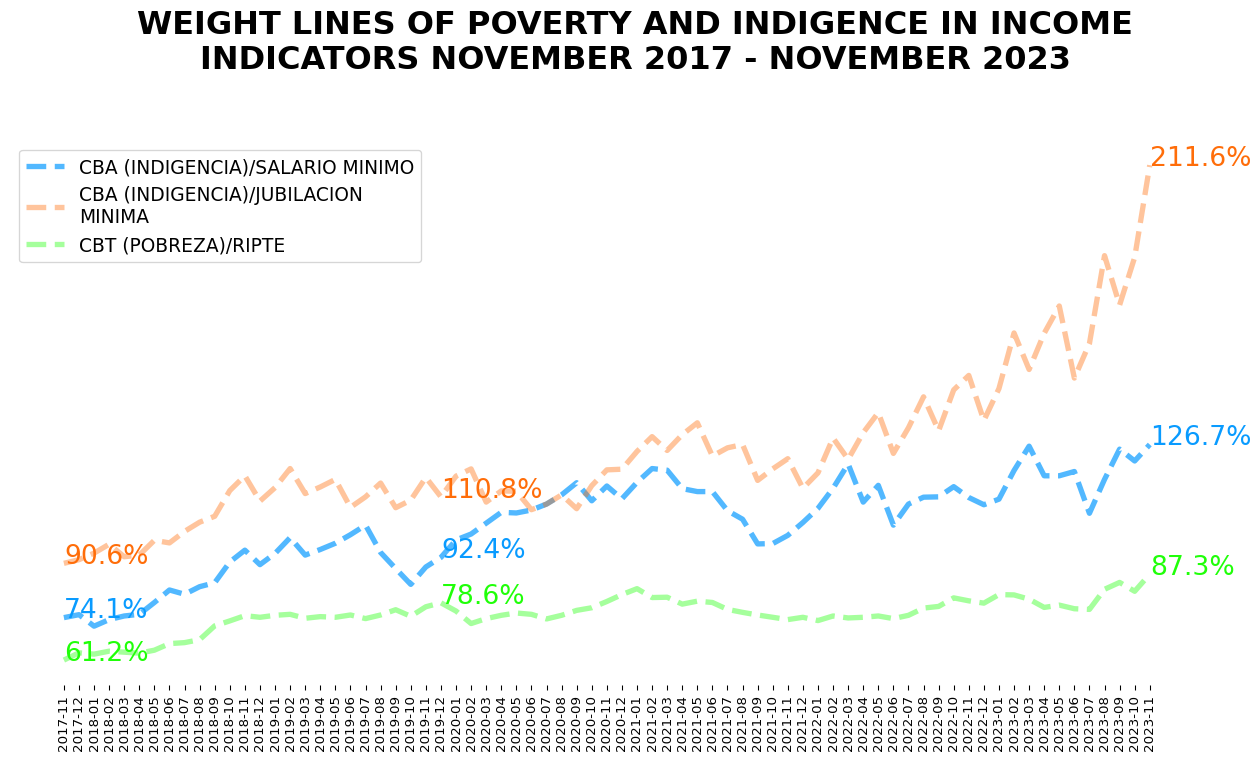

In [5]:
"""
This graph seeks to show the evolution of the purchasing power of income, since the month with the highest level of economic activity (EMAE) of the previous government, through the following indicators:
1-relationship between the value of the CBA (basic food basket, which defines the indigence line) and the value of the minimum retirement.
2-relationship between the value of the CBA (basic food basket, which defines the indigence line) and the value of the minimum wage.
3-relationship between the value of the CBT (Total Basic Basket, which defines the poverty line) and the value of the RIPTE (average remuneration of workers in a dependency relationship).
"""

#DATASETS
CBT = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/150/distribution/150.1/download/valores-canasta-basica-alimentos-canasta-basica-total-mensual-2016.csv")
SMVM = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/57/distribution/57.1/download/indice-salario-minimo-vital-movil-valores-mensuales-pesos-corrientes-desde-1988.csv")
RIPTE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/158/distribution/158.1/download/remuneracion-imponible-promedio-trabajadores-estables-ripte-total-pais-pesos-serie-mensual.csv")
HMJ = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/58/distribution/58.1/download/haber-minimo-jubilatorio-pesos-corrientes-valores-mensuales-desde-1971.csv")
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")

#DEFINITION OF THE PERIOD TO BE ANALYZED (initial date and end date)
#the end date is the last month with available information for the indicator
#iloc allows accessing the value using the position number
fecha_final=CBT['indice_tiempo'].iloc[-1]
#the initial date is the month in which the EMAE shows a higher level during the previous government
#we filter so that only the data from that government period remains and we order from lowest to highest using the relevant column
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#I create a new dataframe where all the datasets are ordered by time period
dfs=[CBT,SMVM,RIPTE,HMJ]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()

#GRAPH
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#variables
x=df["indice_tiempo"].str[:7]
y1=((df["linea_indigencia"]/df["salario_minimo_vital_movil_mensual"])*100).round(1)
y2=((df["linea_indigencia"]/df["mensual_pesos_corrientes"])*100).round(1)
y3=((df["linea_pobreza"]/df["ripte"])*100).round(1)

plt.plot(x, y1, color="#099BFF", linewidth=4, alpha=0.7, linestyle='dashed', label="CBA (INDIGENCIA)/SALARIO MINIMO")
plt.plot(x, y2, color='#ff6d09', linewidth=4, alpha=0.4, linestyle='dashed', label="CBA (INDIGENCIA)/JUBILACION\nMINIMA")
plt.plot(x, y3, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed', label="CBT (POBREZA)/RIPTE")

#rotated x axis labels
plt.tick_params(axis='x', rotation=90)
#I take out the x and y axes
plt.box(False)
#I take off the y axis labels
plt.yticks([])

#ANNOTATIONS
plt.text(x.iloc[-1], y1.tail(1), y1.iloc[-1].round(1).astype(str)+"%", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(x.iloc[-1], y2.tail(1),y2.iloc[-1].round(1).astype(str)+"%", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text(x.iloc[-1], y3.tail(1), y3.iloc[-1].round(1).astype(str)+"%", horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text(x.iloc[0], y1.head(1), y1.iloc[0].round(1).astype(str)+"%", horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text(x.iloc[0], y2.head(1), y2.iloc[0].round(1).astype(str)+"%", horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text(x.iloc[0], y3.head(1), y3.iloc[0].round(1).astype(str)+"%", horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text(x.iloc[25], y1[25], y1.iloc[25].round(1).astype(str)+"%", horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text(x.iloc[25], y2[25], y2.iloc[25].round(1).astype(str)+"%", horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text(x.iloc[25], y3[25], y3.iloc[25].round(1).astype(str)+"%", horizontalalignment='left', color='#20FF09', fontsize=20)

#function that generates the name of a month in the chart
RIPTE["nombre_mes"]=RIPTE["indice_tiempo"].str[5:7]
meses = {"01":"JANUARY","02":"FEBRUARY","03":"MARCH","04":"APRIL","05":"MAY","06":"JUNE","07":"JULY","08":"AUGUST","09":"SEPTEMBER","10":"OCTOBER","11":"NOVEMBER","12": "DECEMBER"}
RIPTE['nombre_mes'].replace(meses, inplace=True)

plt.legend(fontsize=14)

my_suptitle = fig.suptitle("WEIGHT LINES OF POVERTY AND INDIGENCE IN INCOME\nINDICATORS "+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+
                           RIPTE["nombre_mes"].iloc[-1]+" "+RIPTE["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.05, color="black")

plt.tight_layout()

plt.show()

GRAPH 4 - EVOLUTION OF REGISTERED EMPLOYMENT

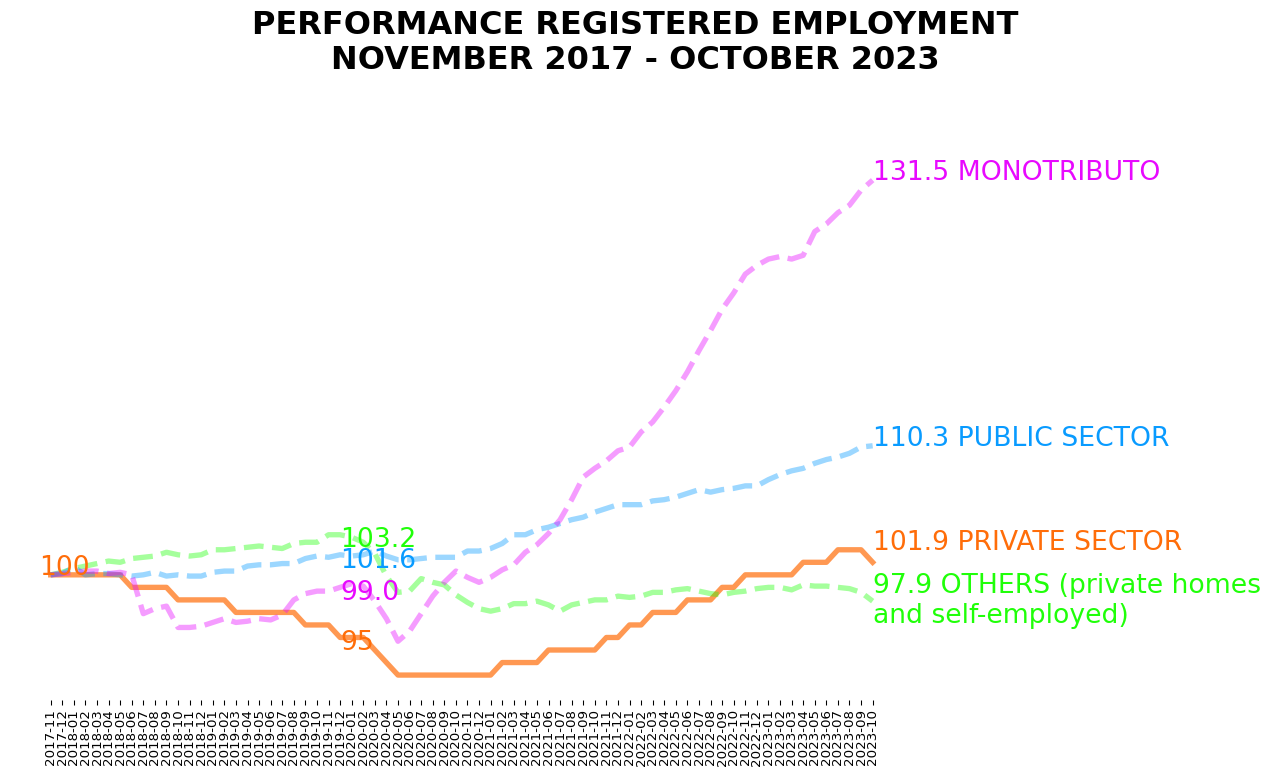

In [6]:
#This graph seeks to show the evolution of the number of workers, from the month with the highest level of economic activity (EMAE) of the previous government to the last month with information

#DATASET
TRA = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/151/distribution/151.1/download/trabajadores-registrados-modalidad-ocupacional-principal-mensual-total-pais-miles-base-2012.csv")
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")

#I create two new categories, which bring together 2 in 1 each
TRA["otros"]=TRA['asalariados_casas_particulares_sin_estac']+TRA['independientes_autonomos_sin_estac']
TRA["monotributo"]=TRA["independientes_monotributo_sin_estac"]+TRA["independientes_monotributo_social_sin_estac"]

#DEFINITION OF THE PERIOD TO BE ANALYZED (initial date and end date)
#the end date is the last month with available information for the indicator
#iloc allows accessing the value using the position number
fecha_final=TRA['indice_tiempo'].iloc[-1]
#the initial date is the month in which the EMAE shows a higher level during the previous government
#we filter so that only the data from that government period remains and we order from lowest to highest using the relevant column
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#I OBTAIN A DATAFRAME OF THE SELECTED INDICATORS IN THE CHOSEN PERIOD
indicadores=['asalariados_priv_sin_estac',"otros",'asalariados_pub_sin_estac','monotributo']
dfs=[TRA]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()

#CALCULATION OF SERIES WITH BASE 100
def prueba (number):
    return number.pct_change()
df[indicadores] = df[indicadores].apply(prueba)
df.loc[0, indicadores]=100
for i in range(1, len(df)):
  df.loc[i, indicadores] = df.loc[i-1, indicadores] * (df.loc[i, indicadores]+1)

#GRAPH
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#variables
x=df["indice_tiempo"].str[:7]
y1=df["asalariados_priv_sin_estac"].astype(int)
y2=df["otros"].round(1)
y3=df["asalariados_pub_sin_estac"].round(1)
y4=df["monotributo"].round(1)

plt.plot(x, y1, color="#ff6d09", linewidth=4, alpha=0.7)
plt.plot(x, y2, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y3, color='#099BFF', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y4, color='#E809FF', linewidth=4, alpha=0.4, linestyle='dashed')

#rotated x axis labels
plt.tick_params(axis='x', rotation=90)
#I take out the x and y axes
plt.box(False)
#I take off the y axis labels
plt.yticks([])

#NOTES ON THE GRAPH
valor_indice=x[x == "2019-12"].index[0]
plt.text(x.tail(1), y2.tail(1)-1.7, df["otros"].iloc[-1].round(1).astype(str)+" OTHERS (private homes\nand self-employed)", horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text(x.tail(1), y3.tail(1), df["asalariados_pub_sin_estac"].iloc[-1].round(1).astype(str)+" PUBLIC SECTOR", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(x.tail(1), y4.tail(1), df["monotributo"].iloc[-1].round(1).astype(str)+" MONOTRIBUTO", horizontalalignment='left', color='#E809FF', fontsize=20)
plt.text(x.tail(1), y1.tail(1)+1, df["asalariados_priv_sin_estac"].iloc[-1].round(1).astype(str)+" PRIVATE SECTOR", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text(-1, y1.head(1), "100", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text("2019-12", y1[valor_indice]-1, y1[valor_indice].astype(str), horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text("2019-12", y2[valor_indice]-1, y2[valor_indice].astype(str), horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text("2019-12", y3[valor_indice]-1, y3[valor_indice].astype(str), horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text("2019-12", y4[valor_indice]-1, y4[valor_indice].astype(str), horizontalalignment='left',  color='#E809FF', fontsize=20)

#function that generates the name of a month in the chart
TRA["nombre_mes"]=TRA["indice_tiempo"].str[5:7]
meses = {"01":"JANUARY","02":"FEBRUARY","03":"MARCH","04":"APRIL","05":"MAY","06":"JUNE","07":"JULY","08":"AUGUST","09":"SEPTEMBER","10":"OCTOBER","11":"NOVEMBER","12": "DECEMBER"}
TRA['nombre_mes'].replace(meses, inplace=True)

my_suptitle = fig.suptitle("PERFORMANCE REGISTERED EMPLOYMENT\n"+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+TRA["nombre_mes"].iloc[-1]+" "+TRA["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.07, color="black")
plt.tight_layout()

plt.tight_layout()

plt.show()